In [57]:
import time
import numpy as np

from scipy.fftpack import dctn, fftn, fftshift, fftfreq
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline, RectSphereBivariateSpline

In [58]:
path = "/Users/zhengzhang/PythonProjects/TIBEC/HIRAX_201.txt"
antenna_sph_coords = np.loadtxt(path,
                                comments=('// >>', '361 181', '#'),
                                usecols=(0, 1),
                                max_rows=361 * 181, ).reshape(-1, 2)

#antenna_sph_coords = np.deg2rad(antenna_sph_coords)

e_field = (np.loadtxt(path,
                      comments=('// >>', '361 181'),
                      usecols=(2, 4),
                      max_rows=361 * 181,
                      ) + 1j * np.loadtxt(path,
                                          comments=('// >>', '361 181'),
                                          usecols=(3, 5),
                                          max_rows=361 * 181,
                                          )).reshape(361, 181, 2)

/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_6804/1651712029.py:2: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=65341`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  antenna_sph_coords = np.loadtxt(path,
/var/folders/69/cq4y0nj97qb_376qpg8lsjf80000gn/T/ipykernel_6804/1651712029.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=65341`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an 

In [59]:
beam_path="/Users/zhengzhang/Dropbox/CarlaShareSept2022/Data 02_09_2022/"
frequencies = np.linspace(400, 800, 201)  # MHz
xs = (frequencies - 400) / 400.
frequency_window = np.sin(np.pi*xs)**4
E1 = loadmat(beam_path + 'E1_S.mat')['E1_S']

In [60]:
# plt.plot(phis)
np.degrees(phis)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [61]:
antenna_sph_coords

array([[  0.,   0.],
       [  0.,   1.],
       [  0.,   2.],
       ...,
       [360., 178.],
       [360., 179.],
       [360., 180.]])

In [62]:
def load_beam_files(beam_file_path):
    E1 = loadmat(beam_file_path + 'E1_S.mat')['E1_S']
    E1_err = loadmat(beam_file_path + 'E1_S_Error.mat')['E1_S']
    valind = loadmat(beam_file_path + 'ValInd.mat')['valInd'].flatten()
    theta = loadmat(beam_file_path + 'th.mat')['th'].flatten()[valind]
    phi = loadmat(beam_file_path + 'ph.mat')['ph'].flatten()[valind]
    valind = np.where(np.rad2deg(theta) < 90)[0]
    E1 = E1[valind]
    E1_err = E1_err[valind]
    theta = theta[valind]
    phi = phi[valind]
    uni_phi, uni_theta = np.unique(phi), np.unique(theta)
    nphi, ntheta =len(uni_phi), len(uni_theta)
    return E1.reshape(nphi, ntheta, -1), E1_err.reshape(nphi, ntheta, -1), \
           uni_phi, uni_theta


def plane2sphere_v2(x, y):
    phi = np.arctan2(y, x)
    theta = 2. * np.arctan(np.sqrt(x ** 2 + y ** 2) / 2.)
    return phi, theta
    

In [63]:
E1, E1_err, phis, thetas = load_beam_files(beam_path)

In [66]:
thetas

array([0.01745329, 0.03490659, 0.05235988, 0.06981317, 0.08726646,
       0.10471976, 0.12217305, 0.13962634, 0.15707963, 0.17453293,
       0.19198622, 0.20943951, 0.2268928 , 0.2443461 , 0.26179939,
       0.27925268, 0.29670597, 0.31415927, 0.33161256, 0.34906585,
       0.36651914, 0.38397244, 0.40142573, 0.41887902, 0.43633231,
       0.45378561, 0.4712389 , 0.48869219, 0.50614548, 0.52359878,
       0.54105207, 0.55850536, 0.57595865, 0.59341195, 0.61086524,
       0.62831853, 0.64577182, 0.66322512, 0.68067841, 0.6981317 ,
       0.71558499, 0.73303829, 0.75049158, 0.76794487, 0.78539816,
       0.80285146, 0.82030475, 0.83775804, 0.85521133, 0.87266463,
       0.89011792, 0.90757121, 0.9250245 , 0.9424778 , 0.95993109,
       0.97738438, 0.99483767, 1.01229097, 1.02974426, 1.04719755,
       1.06465084, 1.08210414, 1.09955743, 1.11701072, 1.13446401,
       1.15191731, 1.1693706 , 1.18682389, 1.20427718, 1.22173048,
       1.23918377, 1.25663706, 1.27409035, 1.29154365, 1.30899

In [36]:
1/np.deg2rad(1)

57.29577951308232

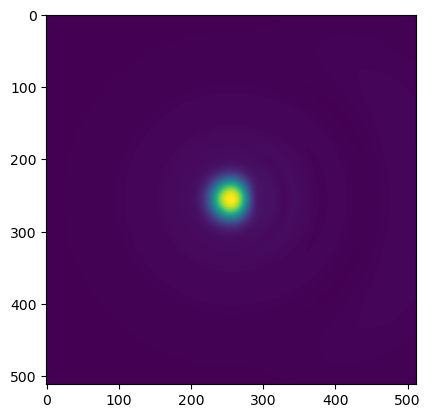

In [44]:
Ndim=512
thetaMax = np.deg2rad(75)
radius = 2.*np.tan(thetaMax/2.)
x_coord, y_coord = np.linspace(-radius, radius, Ndim), np.linspace(-radius, radius, Ndim)
grid_y, grid_x = np.meshgrid(x_coord, y_coord)
target_phi, target_theta = plane2sphere_v2(grid_x.flatten(), grid_y.flatten())


def interpolation(phi, theta, E_field, target_phi, target_theta):
    """
    E_field: (phi, theta, frequency)
    """
    E_interpolated = np.zeros(shape=(Ndim, Ndim, 201))
    for nu in range(201):
        interp = RectSphereBivariateSpline(theta[1:],  # colatitude
                                           phi[:-1],  # longitude
                                           E_field[:-1, 1:, nu].T,   
                                           pole_values=(E_field[0, 0, nu],None),
                                           pole_exact=(True,False))
        E_interpolated[:, :, nu] = interp.ev(target_theta, target_phi).reshape(Ndim, Ndim)
    return E_interpolated

# Interpolation:
E1 = interpolation(phis, thetas, E1, target_phi, target_theta)

import matplotlib.pyplot as plt
plt.imshow(E1[:, :, 0])

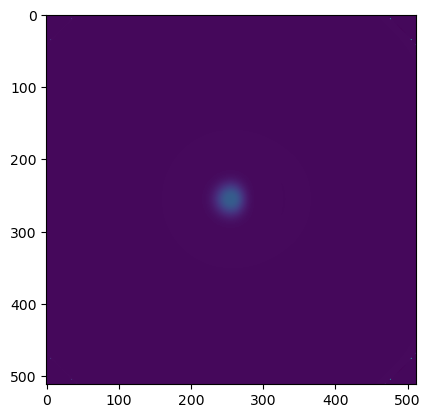

In [30]:
# Rescaling power density for the projected field
grid_target_theta = target_theta.reshape(grid_x.shape)

def field2scaledintensity(E_field, theta_coord):
    aux_theta = theta_coord/2.
    intensity_rescaling_factor = np.cos(aux_theta) ** 5 / (np.cos(aux_theta) - np.sin(aux_theta))
    beam_intensity = intensity_rescaling_factor[:, :, np.newaxis] * np.abs(E_field) ** 2
    return beam_intensity

beam_intensity = field2scaledintensity(E1, grid_target_theta)
plt.imshow(beam_intensity[:, :, 0])

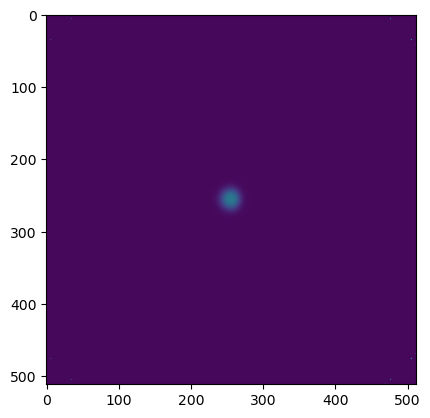

In [31]:
# Normalize the beam
normalization_factor = len(frequencies) / np.linalg.norm(beam_intensity)
beam_intensity *= normalization_factor

def directional_window(E_field, theta_coords, theta_max=75., alpha=0.05):
    for i in range(theta_coords.shape[0]):
        for j in range(theta_coords.shape[1]):
            if theta_coords[i,j] < theta_max:
                E_field[i, j, :] *= np.exp(-alpha*(1/(theta_coords[i,j]-theta_max)**2 - 1/theta_max**2))
            else:
                E_field[i, j, :] = 0.
    return E_field
    
beam_intensity = directional_window(beam_intensity, grid_target_theta, 75.)
plt.imshow(beam_intensity[:, :, 101])

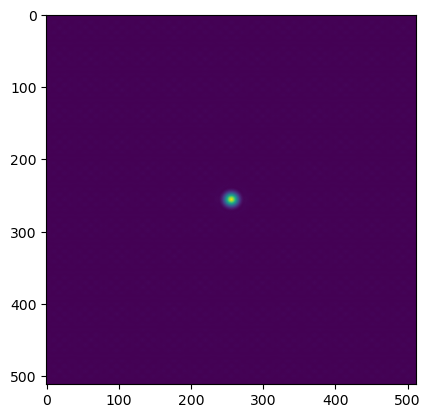

In [32]:
# Beam pixel resolutions
x_res = np.abs(x_coord[1] - x_coord[0])
y_res = np.abs(y_coord[1] - y_coord[0])

x_fft_coords = fftshift(fftfreq(x_coord.size, d=x_res))
y_fft_coords = fftshift(fftfreq(y_coord.size, d=y_res))
                                
Beam_fft = fftshift(fftn(beam_intensity, axes=(0, 1)), axes=(0, 1))

plt.imshow(np.abs(Beam_fft[:, :, 0])) 

In [37]:
Beam_fft.shape

(512, 512, 201)

In [ ]:
Ndim=512
thetaMax = np.deg2rad(75)
radius = 2.*np.tan(thetaMax/2.)
x_coord, y_coord = np.linspace(-radius, radius, Ndim), np.linspace(-radius, radius, Ndim)
grid_y, grid_x = np.meshgrid(x_coord, y_coord)
target_phi, target_theta = plane2sphere_v2(grid_x.flatten(), grid_y.flatten())


def interpolation(phi, theta, E_field, target_phi, target_theta):
    E_interpolated = np.zeros(shape=(Ndim, Ndim, 201))
    for nu in range(201):
        interp = RectSphereBivariateSpline(theta[1:], phi[:-1], E_field[:-1, 1:, nu].T, 
                                           pole_values=(E_field[0, 0, nu],None),
                                           pole_exact=(True,False))
        E_interpolated[:, :, nu] = interp.ev(target_theta, target_phi).reshape(Ndim, Ndim)
    return E_interpolated

def interpolation_k_space(qx, qy, Beam_fft, target_qx, target_qy):
    FFTBeam_interpolated = np.zeros(shape=(Ndim, Ndim))
    for nu in range(201):
        interp = RectSphereBivariateSpline(theta[1:], phi[:-1], E_field[:-1, 1:, nu].T, 
                                           pole_values=(E_field[0, 0, nu],None),
                                           pole_exact=(True,False))
        E_interpolated[:, :, nu] = interp.ev(target_theta, target_phi).reshape(Ndim, Ndim)
    return E_interpolated

RectBivariateSpline

# Interpolation:
E1 = interpolation(phis, thetas, E1, target_phi, target_theta)

import matplotlib.pyplot as plt
plt.imshow(E1[:, :, 0])

In [17]:
import numpy.ma as ma

def mask_k_modes(k_x, k_y, radius1=8, radius2=320):
    grid_fft_y, grid_fft_x = np.meshgrid(x_fft_coords, y_fft_coords)
    aux = np.sqrt((grid_fft_x - k_x)**2 + (grid_fft_y - k_y)**2)
    return ma.masked_outside(aux, radius1, radius2).mask

x = np.ma.array(Beam_fft[:,:,0], mask=mask_k_modes(5,0)).sum()


In [13]:
import numpy.ma as ma

ma.masked_outside(aux, 8, 320)

masked_array(
  data=[[62.38267060034609, 62.16703673386323, 61.95235238070864, ...,
         61.73862744613998, 61.95235238070864, 62.16703673386323],
        [62.14092950421388, 61.924453850525765, 61.70892556121756, ...,
         61.494354597391, 61.70892556121756, 61.924453850525765],
        [61.899945817907245, 61.68262443588202, 61.46624818981604, ...,
         61.250827096144896, 61.46624818981604, 61.68262443588202],
        ...,
        [54.68626841916048, 54.44015814314544, 54.194873631042626, ...,
         53.95042614580957, 54.194873631042626, 54.44015814314544],
        [54.89789124876176, 54.65273395356439, 54.408407786233596, ...,
         54.164923993880564, 54.408407786233596, 54.65273395356439],
        [55.11061256876988, 54.866405775695505, 54.623035360342875, ...,
         54.38051255189714, 54.623035360342875, 54.866405775695505]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, Fal

In [14]:
ma.masked_outside(aux, 8, 320).mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [16]:
x.sum()

(-99.81474638970273-3.0181423314085496j)